# $\Phi$-SO demo

## Packages import

In [1]:
# conda env
!echo $CONDA_PREFIX

/opt/homebrew/Caskroom/miniforge/base/envs/PhySO


In [2]:
# External packages
import torch
import numpy as np

# Pyplot
%matplotlib inline
import matplotlib.pyplot as plt

# Internal code import
import physo
from physo.learn import monitoring
from physo.task  import benchmark

In [3]:
# Device
DEVICE = 'cpu'
if torch.cuda.is_available():
    DEVICE = 'cuda'
print(DEVICE)

cpu


In [4]:
torch.cuda.is_available()

False

## Test case

In [5]:
data_size = int(1e3)

In [6]:
# Data points
c = 10.
data_lowbound, data_upbound = -10, 10
m = np.random.uniform(data_lowbound, data_upbound, data_size)
data_lowbound, data_upbound = -0.9*c, 0.9*c
v = np.random.uniform(data_lowbound, data_upbound, data_size)
x0_array = m
x1_array = v
X_array = np.stack((x0_array, x1_array), axis=0)
y_array = m*(c**2)*(1/(1-((v**2)/(c**2)))**0.5)

# One of many symbolic solutions:
target_program_str = ["mul", "mul", "m", "n2", "c", "inv", "sqrt", "sub", "1", "div", "n2", "v", "n2", "c",]
print(len(target_program_str))


14


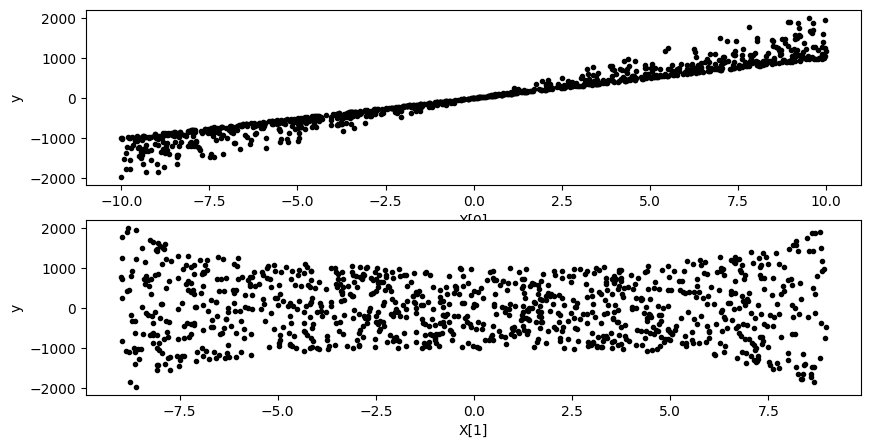

In [7]:
n_dim = X_array.shape[0]
fig, ax = plt.subplots(n_dim, 1, figsize=(10,5))
for i in range (n_dim):
    curr_ax = ax if n_dim==1 else ax[i]
    curr_ax.plot(X_array[i], y_array, 'k.',)
    curr_ax.set_xlabel("X[%i]"%(i))
    curr_ax.set_ylabel("y")
plt.show()

In [8]:
# ------ Vectors ------
# Stack of all input variables
X = torch.tensor(X_array).to(DEVICE)
# Output of symbolic function to guess
y = torch.tensor(y_array).to(DEVICE)

# ------ Constants ------
const1 = torch.tensor(np.array(1.) .astype(float)).to(DEVICE)
c      = torch.tensor(np.array(c)  .astype(float)).to(DEVICE)

## Run config

### Library config

In [9]:
args_make_tokens = {
                # operations
                "op_names"             : ["mul", "add", "sub", "div", "inv", "n2", "sqrt", "exp", "log", "sin", "cos"],
                "use_protected_ops"    : True,
                # input variables
                "input_var_ids"        : {"m" : 0         , "v" : 1         ,},
                "input_var_units"      : {"m" : [0, 0, 1] , "v" : [1, -1, 0] ,},
                "input_var_complexity" : {"m" : 1.        , "v" : 1.        ,},
                # constants
                "constants"            : {"1" : const1    , "c" : c          },
                "constants_units"      : {"1" : [0, 0, 0] , "c" : [1, -1, 0] },
                "constants_complexity" : {"1" : 1.        , "c" : 1.         },
                # free constants
                #"free_constants"            : {"c"              },
                #"free_constants_init_val"   : {"c" : 1.         },
                #"free_constants_units"      : {"c" : [1, -1, 0] },
                #"free_constants_complexity" : {"c" : 1.         },
                    }

library_config = {"args_make_tokens"  : args_make_tokens,
                "superparent_units" : [2, -2, 1],
                "superparent_name"  : "E",
                }

### Free constant optimizer config

In [10]:
free_const_opti_args = {
            'loss'   : "MSE",
            'method' : 'LBFGS',
            'method_args': {
                        'n_steps' : 30,
                        'tol'     : 1e-8,
                        'lbfgs_func_args' : {
                            'max_iter'       : 4,
                            'line_search_fn' : "strong_wolfe",
                                             },
                            },
        }

### Learning config

In [11]:
MAX_TRIAL_EXPRESSIONS = 2*1e6
BATCH_SIZE = int(1e4)
MAX_LENGTH = 35
GET_OPTIMIZER = lambda model : torch.optim.Adam(
                                    model.parameters(),                
                                    lr=0.0025, #0.001, #0.0050, #0.0005, #1,  #lr=0.0025
                                                )

In [12]:
reward_config = {
                 "reward_function"     : physo.physym.reward.SquashedNRMSE, # PHYSICALITY
                 "zero_out_unphysical" : True,
                 "zero_out_duplicates" : False,
                 "keep_lowest_complexity_duplicate" : False,
                }

In [13]:
learning_config = {
    # Batch related
    'batch_size'      : BATCH_SIZE,
    'max_time_step'   : MAX_LENGTH,
    'n_epochs'        : int(1e9), # int(MAX_TRIAL_EXPRESSIONS/BATCH_SIZE),
    # Loss related
    'gamma_decay'     : 0.7,
    'entropy_weight'  : 0.03,
    # Reward related
    'risk_factor'      : 0.05,
    'rewards_computer' : physo.physym.reward.make_RewardsComputer (**reward_config),
    # Optimizer
    'get_optimizer'   : GET_OPTIMIZER,
}

### Priors config

In [14]:
priors_config  = [
                #("UniformArityPrior", None),
                # LENGTH RELATED
                ("HardLengthPrior"  , {"min_length": 4, "max_length": MAX_LENGTH, }),
                ("SoftLengthPrior"  , {"length_loc": 8, "scale": 5, }),
                # RELATIONSHIPS RELATED
                ("NoUselessInversePrior"  , None),
                ("PhysicalUnitsPrior", {"prob_eps": np.finfo(np.float32).eps}), # PHYSICALITY
                ("NestedFunctions", {"functions":["exp",], "max_nesting" : 1}),
                ("NestedFunctions", {"functions":["log",], "max_nesting" : 1}),
                ("NestedTrigonometryPrior", {"max_nesting" : 1}),           
                #("OccurrencesPrior", {"targets" : ["1",], "max" : [3,] }),
                 ]

### Cell config

In [15]:
cell_config = {
    "hidden_size" : 128,
    "n_layers"    : 1,
}

### Logger

In [16]:
save_path_training_curves = 'RelatE_curves.png'
save_path_log             = 'RelatE.log'

run_logger     = monitoring.RunLogger(save_path = save_path_log, 
                                      do_save = True)

run_visualiser = monitoring.RunVisualiser (epoch_refresh_rate = 20,
                                           save_path = save_path_training_curves,
                                           do_show   = False,
                                           do_prints = True,
                                           do_save   = True, )

### Run config

In [17]:
run_config = {
    "learning_config"      : learning_config,
    "reward_config"        : reward_config,
    "free_const_opti_args" : free_const_opti_args,
    "library_config"       : library_config,
    "priors_config"        : priors_config,
    "cell_config"          : cell_config,
    "run_logger"           : run_logger,
    "run_visualiser"       : run_visualiser,
}

## Dummy epoch for prior tuning

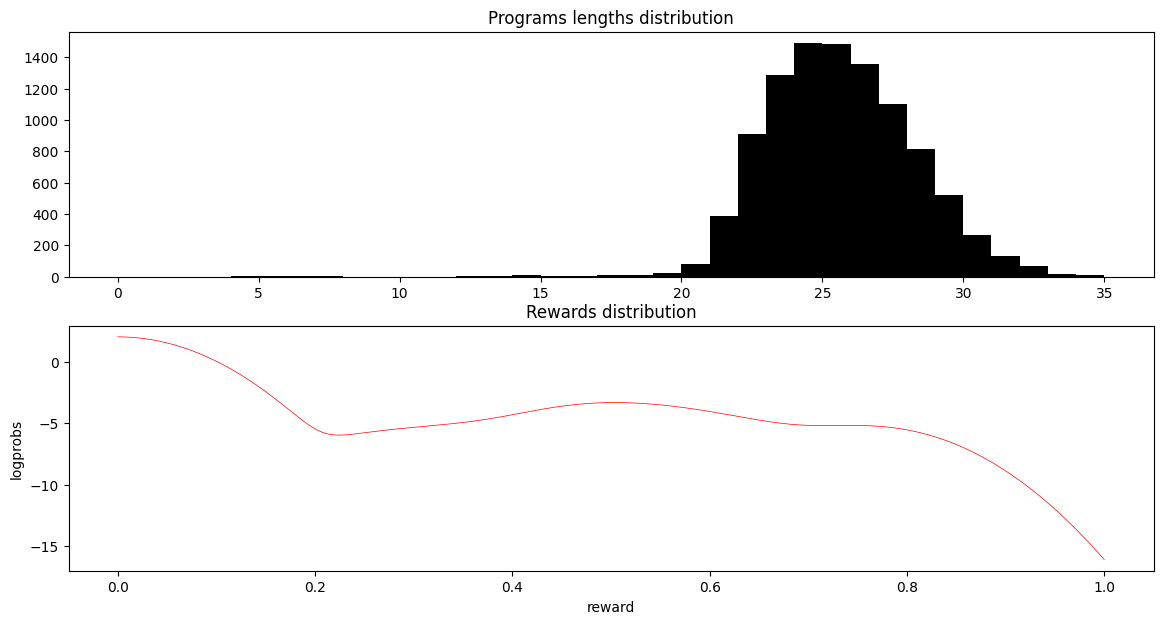

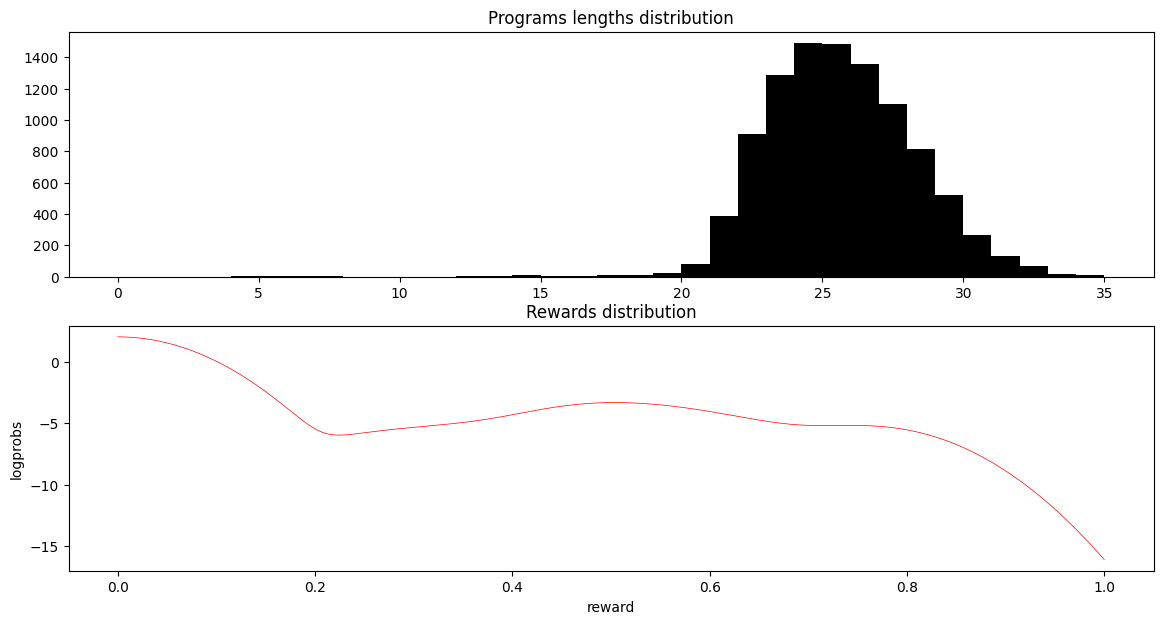

In [18]:
benchmark.dummy_epoch(X, y, run_config)

## Sanity checks

Data


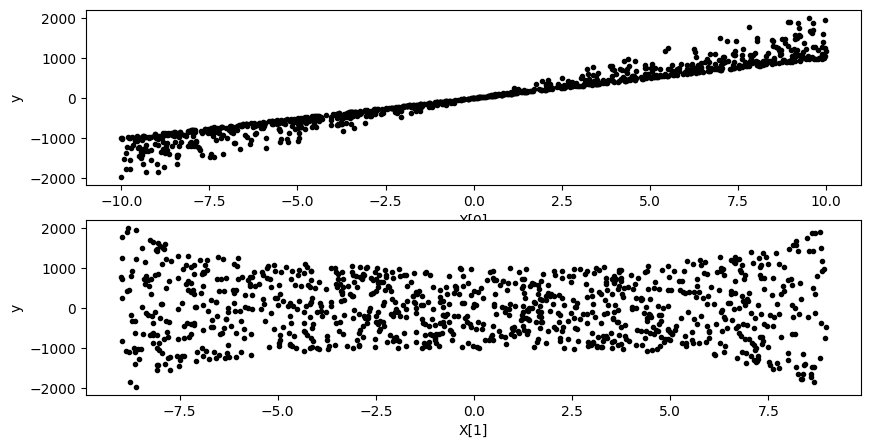

{'mul': 0, 'add': 1, 'sub': 2, 'div': 3, 'inv': 4, 'n2': 5, 'sqrt': 6, 'exp': 7, 'log': 8, 'sin': 9, 'cos': 10, '1': 11, 'c': 12, 'm': 13, 'v': 14}
-------------------------- Library -------------------------
[mul add sub div inv n2 sqrt exp log sin cos 1 c m v E dummy -]
--------------------------- Prior --------------------------
PriorCollection:
- HardLengthPrior (min_length = 4, max_length = 35)
- SoftLengthPrior (length_loc = 8, scale = 5)
- NoUselessInversePrior (['inv', 'log', 'exp', 'n2', 'sqrt'] can not be child of ['inv', 'exp', 'log', 'sqrt', 'n2'])
- PhysicalUnitsPrior
- NestedFunctions (tokens = ['exp'], nesting forbidden)
- NestedFunctions (tokens = ['log'], nesting forbidden)
- NestedTrigonometryPrior (tokens = ['sin' 'cos'], nesting forbidden)
-------------------------- Dataset -------------------------
X        : torch.Size([2, 1000]) 
y_target : torch.Size([1000])
-------------------------- Programs ------------------------
[['dummy' '-' '-' ... '-' '-' '-']
 ['dummy'

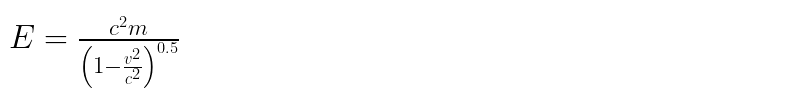

Simplified expression:


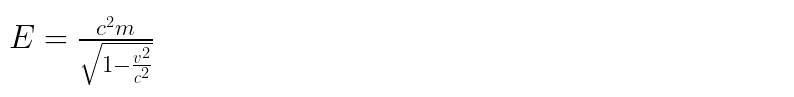

Ideal reward : 1.0


In [19]:
target_program = benchmark.sanity_check(X, y, run_config, target_program_str=target_program_str)

## Run

In [ ]:
rewards, candidates = physo.fit(X, y, run_config)

/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:519: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00000 ===========
-> Time 10.05 s

Overall best  at R=0.811508
-> Raw expression : 
                     m                     
───────────────────────────────────────────
⎛   ⎛ ⎛                              0.5⎞⎞⎞
⎜   ⎜ ⎝(-1 + log(-1 + 1⋅(1 + 1)) + 1)   ⎠⎟⎟
⎜sin⎝ℯ                                   ⎠⎟
⎜─────────────────────────────────────────⎟
⎝                   c⋅c                   ⎠

Best of epoch at R=0.811508
-> Raw expression : 
                     m                     
───────────────────────────────────────────
⎛   ⎛ ⎛                              0.5⎞⎞⎞
⎜   ⎜ ⎝(-1 + log(-1 + 1⋅(1 + 1)) + 1)   ⎠⎟⎟
⎜sin⎝ℯ                                   ⎠⎟
⎜─────────────────────────────────────────⎟
⎝                   c⋅c                   ⎠


=========== Epoch 00001 ===========
-> Time 21.35 s

Overall best  at R=0.811508
-> Raw expression : 
                     m                     
───────────────────────────────────────────
⎛   ⎛ ⎛                              0.5

/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/learn/monitoring.py:519: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.savefig(self.save_path)


=========== Epoch 00020 ===========
-> Time 66.08 s

Overall best  at R=0.931666
-> Raw expression : 
 2           1    
v ⋅m⋅1 + ─────────
              1   
         1⋅───────
           ⎛  c  ⎞
           ⎜─────⎟
           ⎜⎛ 1 ⎞⎟
           ⎜⎜───⎟⎟
           ⎝⎝c⋅m⎠⎠

Best of epoch at R=0.812217
Unable to print status.
=========== Epoch 00021 ===========
-> Time 50.00 s

Overall best  at R=0.931666
-> Raw expression : 
 2           1    
v ⋅m⋅1 + ─────────
              1   
         1⋅───────
           ⎛  c  ⎞
           ⎜─────⎟
           ⎜⎛ 1 ⎞⎟
           ⎜⎜───⎟⎟
           ⎝⎝c⋅m⎠⎠

Best of epoch at R=0.811508
-> Raw expression : 
    c⋅m⋅sin(1)   
─────────────────
1    ⎛1⎞         
─⋅sin⎜─⎟⋅sin(1⋅1)
c    ⎝1⎠         


=========== Epoch 00022 ===========
-> Time 20.21 s

Overall best  at R=0.931666
-> Raw expression : 
 2           1    
v ⋅m⋅1 + ─────────
              1   
         1⋅───────
           ⎛  c  ⎞
           ⎜─────⎟
           ⎜⎛ 1 ⎞⎟
           ⎜⎜───⎟⎟
     

## Results

### Run plot

In [ ]:
run_visualiser.make_visualisation()

### Pareto Front

In [ ]:
def plot_pareto_front(run_logger,
                      do_simplify                   = True,
                      show_superparent_at_beginning = True,
                      eq_text_size                  = 12,
                      delta_xlim                    = [0, 5 ],
                      delta_ylim                    = [0, 15],
                      frac_delta_equ                = [0.03, 0.03],
                      figsize                       = (20, 10),
                     ):

    pareto_front_complexities, pareto_front_programs, pareto_front_r, pareto_front_rmse = run_logger.get_pareto_front()

    pareto_front_rmse = np.log(pareto_front_rmse)
    # Fig params
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    # enables new_dummy_symbol = "\square"
    plt.rc('text.latex', preamble=r'\usepackage{amssymb} \usepackage{xcolor}')
    plt.rc('font', size=32)

    # Fig
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.plot(pareto_front_complexities, pareto_front_rmse, 'r-')
    ax.plot(pareto_front_complexities, pareto_front_rmse, 'ro')

    # Limits
    xmin = pareto_front_complexities.min() + delta_xlim[0]
    xmax = pareto_front_complexities.max() + delta_xlim[1]
    ymin = pareto_front_rmse.min() + delta_ylim[0]
    ymax = pareto_front_rmse.max() + delta_ylim[1]
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

    # Axes labels
    ax.set_xlabel("Expression complexity")
    ax.set_ylabel("log(RMSE)")


    for i_prog in range (len(pareto_front_programs)):
        prog = pareto_front_programs[i_prog]

        text_pos  = [pareto_front_complexities[i_prog] + frac_delta_equ[0]*(xmax-xmin), 
                     pareto_front_rmse[i_prog]         + frac_delta_equ[1]*(ymax-ymin)]
        # Getting latex expr
        latex_str = prog.get_infix_latex(do_simplify = do_simplify)
        # Adding "superparent =" before program to make it pretty
        if show_superparent_at_beginning:
            latex_str = prog.library.superparent.name + ' =' + latex_str


        ax.text(text_pos[0], text_pos[1], f'${latex_str}$', size = eq_text_size)

In [ ]:
plot_pareto_front(run_logger)


In [ ]:
pareto_front_complexities, pareto_front_programs, pareto_front_r, pareto_front_rmse = run_logger.get_pareto_front()


In [ ]:
for prog in pareto_front_programs:
    prog.show_infix(do_simplify=True)

### Symbolic equivalence

In [ ]:
best_prog_sympy   = candidates[-1] .get_infix_sympy(do_simplify=True)
target_prog_sympy = target_program .get_infix_sympy(do_simplify=True)

In [ ]:
target_prog_sympy

In [ ]:
best_prog_sympy

In [ ]:
target_prog_sympy == best_prog_sympy

In [ ]:
hall_of_fame = run_logger.hall_of_fame

In [ ]:
for i in range(len(hall_of_fame)):
    print(hall_of_fame[i].get_infix_sympy(do_simplify=False))

In [ ]:
eq = hall_of_fame[i].get_infix_sympy(do_simplify=True)

In [ ]:
for prog in pareto_front_programs:
    prog.show_infix(do_simplify=True)
    print("g", prog.free_const_values[0])
    print("m", prog.free_const_values[1])